# Data preparing

This dataset is about a skin canncer classification task. It comes from Kaggle Datasets https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000. 

<img src="https://i.imgur.com/LYVdBE0.png" title="source: imgur.com" />

The dataset (6GB) contains 10015 images and 1 ground truth response CSV file. 

Cases include a representative collection of all important diagnostic categories in the realm of pigmented lesions: 
- Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec)
- basal cell carcinoma (bcc)
- benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl)
- dermatofibroma (df)
- melanoma (mel)
- melanocytic nevi (nv)
- vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).

For preparing the dataset, split them, 60% goes to training set, 20% goes to validating set and the rest goes to the testing set.

For passing data to dataloader easily, I moved X_train into dataset/train, X_val to dataset/val and X_test to dataset/test, and for each class, make a folder name with class name and store the corresponding images. Just like the figure shows below.

<img src="https://i.imgur.com/VfVyZsx.png" title="source: imgur.com" width="40%"/>

# Dataset & DataLoader

Connect to my google drive, you can also use this link (https://drive.google.com/drive/folders/1U1jRNoDF1-__qIWq1Q0tHjuOXUrXF0VV?usp=sharing), and create a shortcut to your google drvie.

In [1]:
!pip install -q transformers datasets

     |████████████████████████████████| 5.3 MB 30.2 MB/s 
     |████████████████████████████████| 441 kB 54.0 MB/s 
     |████████████████████████████████| 163 kB 69.9 MB/s 
     |████████████████████████████████| 7.6 MB 56.4 MB/s 
     |████████████████████████████████| 115 kB 73.8 MB/s 
     |████████████████████████████████| 212 kB 68.2 MB/s 
     |████████████████████████████████| 127 kB 66.2 MB/s 
     |████████████████████████████████| 115 kB 73.7 MB/s 


In [2]:
from google.colab import drive

drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [3]:
cd gdrive/MyDrive/lsml2_final_project/

/content/gdrive/MyDrive/lsml2_final_project


In [ ]:
#! unzip HAM10000_dataset.zip

In [5]:
from datasets import load_dataset

data_files = {'train': ['HAM10000_dataset/Train/**'], 
              'val': ['HAM10000_dataset/Val/**'],
              'test': ['HAM10000_dataset/Test/**']}

dataset = load_dataset("imagefolder", data_files=data_files)

Resolving data files:   0%|          | 0/6009 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2003 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2003 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-3d0f731bf0c64601/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
labels = dataset['train'].features['label'].names
print(len(labels))
labels

7


['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [7]:
len(dataset['train']), len(dataset['val']), len(dataset['test'])

(6009, 2003, 2003)

In [8]:
id2label = {k:v for k,v in enumerate(labels)}
label2id = {v:k for k,v in enumerate(labels)}
print(id2label)
print(label2id)

{0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


## Data distribution

We can find that this is an imbalance dataset, so I will use F1-score as the main metric to evulate the model performance. And for the loss function, I will calculate the weights of difference classes, and use weighted loss function.

In [9]:
import pandas as pd

df = pd.read_csv('HAM10000_metadata.csv')
print(df.shape)
df.head()

(10015, 7)


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


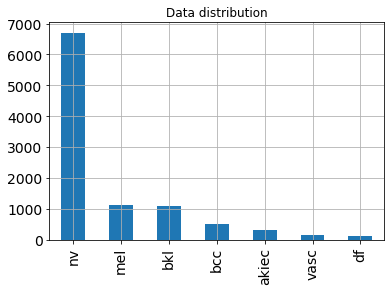

In [10]:
import matplotlib.pyplot as plt

df['dx'].value_counts().plot.bar(fontsize=14)
plt.grid()
plt.title('Data distribution')
plt.show()

## Visualize data

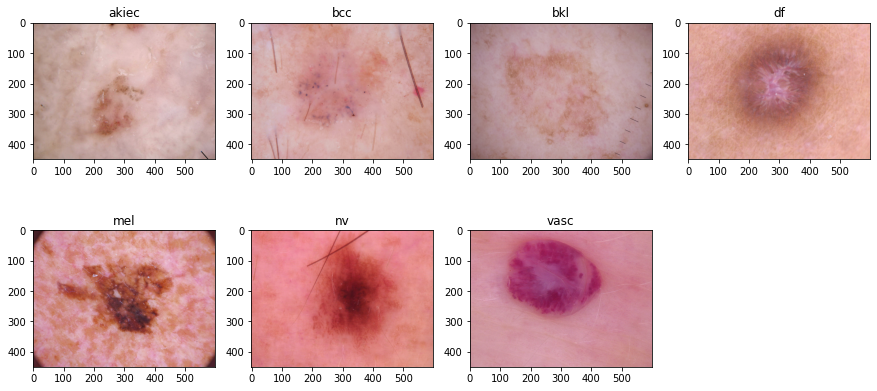

In [11]:
examples = dataset["train"][[0, 194, 497, 1138, 1199, 1858, 5911]]

plt.figure(figsize=(15, 7))
for i, img in enumerate(examples["image"]):
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(id2label[examples['label'][i]])

# Data Augmentation

In this part:
- resize image to 224 x 224
- Random Horizontal Flip
- Normalize the data with mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]

In [12]:
from torchvision.transforms import Compose, Normalize, RandomHorizontalFlip, RandomResizedCrop, ToTensor

def train_transforms(examples):
    examples["pixel_values"] = [transform(image.convert("RGB")) for image in examples["image"]]
    return examples

normalize = Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])

transform = Compose(
    [
     RandomResizedCrop(224),
     RandomHorizontalFlip(),
     ToTensor(),
     normalize
    ]
)

processed_dataset = dataset.with_transform(train_transforms)

## Visualize

Text(0.5, 1.0, 'transform')

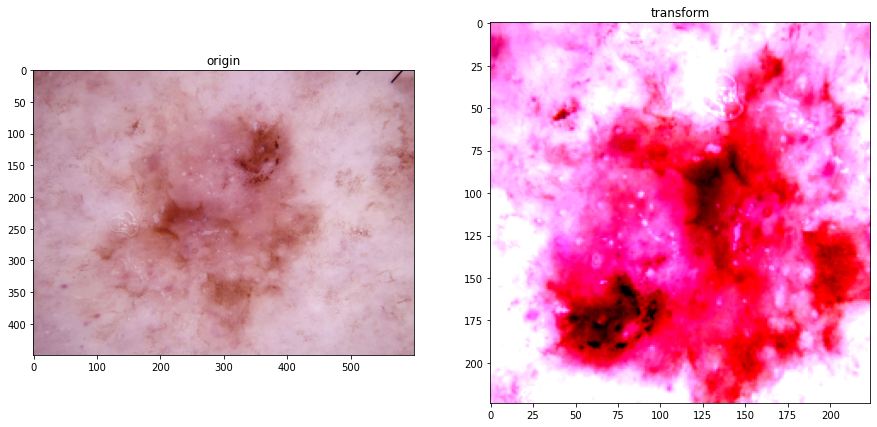

In [13]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(dataset['train'][1]['image'])
plt.title('origin')
plt.subplot(1, 2, 2)
plt.imshow(processed_dataset["train"][1]["pixel_values"].permute(2, 1, 0).numpy())
plt.title('transform')

# DataLoader

Pass the dataset to dataloader, with batch size = 8

In [14]:
from torch.utils.data import DataLoader
import torch 

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

batch_size = 8
dataloader = DataLoader(processed_dataset["train"], collate_fn=collate_fn, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(processed_dataset["val"], collate_fn=collate_fn, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(processed_dataset["test"], collate_fn=collate_fn, batch_size=batch_size, shuffle=True)

# Modeling

In this part, I will train the model from scratch. Because our dataset not very large, so I will train 2 models, which are Resnet18 (without pretrained) and Resnet50 (without pretrained) respectively.

In [15]:
import torchvision
import torch.nn as nn

In [16]:
class custom_resnet(nn.Module):
    def __init__(self, in_channel=3, out_features=7, backbone="resnet18"):
        super().__init__()
        if backbone == "resnet18":
            self.resnet = torchvision.models.resnet18(pretrained=None)
            self.out = nn.Linear(in_features=512, out_features=out_features, bias=True)
        elif backbone == "resnet50":
            self.resnet = torchvision.models.resnet50(pretrained=None)
            self.out = nn.Linear(in_features=2048, out_features=out_features, bias=True)

        self.backbone = nn.Sequential(
            nn.Conv2d(in_channel, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
            self.resnet.bn1,
            self.resnet.relu,
            self.resnet.maxpool,
            self.resnet.layer1,
            self.resnet.layer2,
            self.resnet.layer3,
            self.resnet.layer4,
            self.resnet.avgpool,
            nn.Flatten(start_dim=1)
        )


    def forward(self, img):
        x = self.backbone(img)
        return self.out(x)


In [17]:
def model_testing(model, dataloader):
    model.eval() # eval mode
    correct = 0
    total = 0
    for idx, batch in enumerate(tqdm(dataloader)):
        batch = {k:v.to(device) for k,v in batch.items()}
        with torch.no_grad():
            logits = model(batch["pixel_values"])
            prediction = logits.argmax(dim=-1)
            loss = criterion(logits, batch['labels'])

        # metrics
        total += batch["labels"].shape[0]
        predicted = logits.argmax(-1)
        correct += (predicted == batch["labels"]).sum().item()
        accuracy = correct/total

        y_true = batch["labels"]
        logits_ = logits if idx == 0 else torch.vstack((logits_, logits))
        predicted_ = predicted if idx == 0 else torch.hstack((predicted_, predicted))
        y_true_ = y_true if idx == 0 else torch.hstack((y_true_, y_true))

    y_score = m(logits_).detach().cpu().numpy()
    y_true = y_true_.detach().cpu().numpy()
    y_pred = predicted_.detach().cpu().numpy()
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted') # sensitivity
    f1 = 2 * precision * recall / (precision + recall)
    return {'acc': accuracy, 'f1': f1, 'precision': precision, 'recall': recall, 'loss': loss.item()}


In [18]:
def train_model(model, dataloader, val_dataloader, model_name, criterion, optimizer, num_epochs=15):
    m = torch.nn.Softmax(dim=1)
    print(f"training: {model_name}")
    
    train_log = {'acc': [], 'f1': [], 'precision': [], 'recall': [], 'loss': []}
    val_log = {'acc': [], 'f1': [], 'precision': [], 'recall': [], 'loss': []}
    
    for epoch in range(num_epochs):
        print(f"Epoch: {epoch}/{num_epochs - 1}")
        correct = 0
        total = 0
        model.train()
        for idx, batch in enumerate(tqdm(dataloader)):
            # move batch to GPU
            batch = {k:v.to(device) for k,v in batch.items()}

            optimizer.zero_grad()

            # forward pass
            logits = model(batch["pixel_values"])
            prediction = logits.argmax(dim=-1)

            loss = criterion(logits, batch['labels'])
            loss.backward()
            optimizer.step()

            # metrics
            total += batch["labels"].shape[0]
            predicted = logits.argmax(-1)
            correct += (predicted == batch["labels"]).sum().item()
            accuracy = correct/total

            y_true = batch["labels"]
            logits_ = logits if idx == 0 else torch.vstack((logits_, logits))
            predicted_ = predicted if idx == 0 else torch.hstack((predicted_, predicted))
            y_true_ = y_true if idx == 0 else torch.hstack((y_true_, y_true))

            if idx % 100 == 0:
                print(f"Loss after {idx} steps:", loss.item())
                print(f"Accuracy after {idx} steps:", accuracy)

        y_score = m(logits_).detach().cpu().numpy()
        y_true = y_true_.detach().cpu().numpy()
        y_pred = predicted_.detach().cpu().numpy()
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = 2 * precision * recall / (precision + recall)

        # save the train acc and loss
        train_log['acc'].append(accuracy)
        train_log['precision'].append(precision)
        train_log['recall'].append(recall)
        train_log['f1'].append(f1)
        train_log['loss'].append(loss.item())

        with open(f"train_log_{model_name}.json", "w") as outfile:
            json.dump(train_log, outfile)

        # eval
        model.eval() # eval mode
        print('validating:')
        result_val = model_testing(model, val_dataloader)

        # save the train acc and loss
        val_log['acc'].append(result_val['acc'])
        val_log['precision'].append(result_val['precision'])
        val_log['recall'].append(result_val['recall'])
        val_log['f1'].append(result_val['f1'])
        val_log['loss'].append(result_val['loss'])

        with open(f"val_log_{model_name}.json", "w") as outfile:
            json.dump(val_log, outfile)

        model_path = f"models/{model_name}_{epoch}.pth"
        torch.save(model.state_dict(), model_path)

        # plot
        display.clear_output()
        plt.figure(figsize=(20, 10))
        for i, key in enumerate(train_log.keys()):
            plt.subplot(3, 2, i+1)
            plt.plot(train_log[key], 'x-', label=f'train_{key}')
            plt.plot(val_log[key], 'x-', label=f'val_{key}')
            plt.grid()
            plt.legend()
        plt.show()

Since the dataset is imbalance, here I will calculate the class weights, and pass it to the loss function. Class weight allowing the model to pay more attention to examples from the minority class than the majority class in datasets with a severely skewed class distribution. Hence, the minority class will have a large weight.

In [21]:
from collections import Counter

y = dataset['train']['label']
weigths = Counter(y)
total = len(y)
max_class_freq = weigths[5]/total
class_weights = torch.tensor([1/(weigths[i]/total/max_class_freq) for i in range(7)])

In [22]:
class_weights

tensor([20.8918, 13.3762,  6.3229, 66.4426,  6.1502,  1.0000, 41.3571])

## Resnet18

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = custom_resnet(backbone="resnet18")
model.to(device)
print(device)

cuda


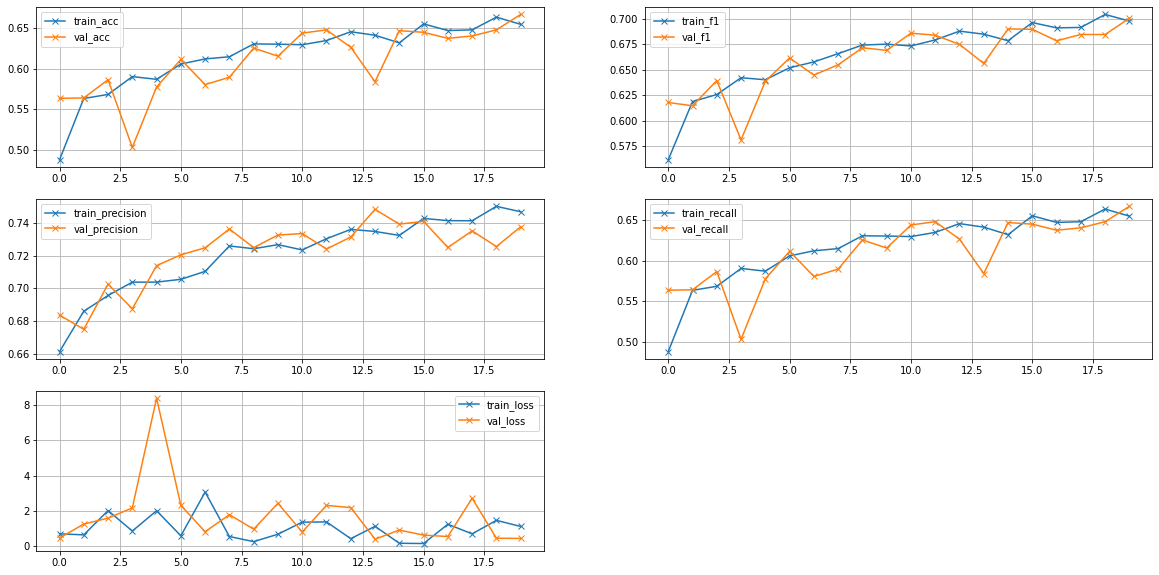

In [ ]:
from tqdm.notebook import tqdm
from IPython import display
from sklearn.metrics import precision_score, recall_score, roc_auc_score
import numpy as np

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

m = torch.nn.Softmax(dim=1)

train_model(
    model=model,
    dataloader=dataloader,
    val_dataloader=val_dataloader,
    model_name="resnet18",
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=20
)

After training 20 epochs, we can find that the loss not decrease significantly. At 19 epoch, has the highest f1-score, so I will select this model as the best model.

## Resnet50

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = custom_resnet(backbone="resnet50")
model.to(device)
print(device)

cuda


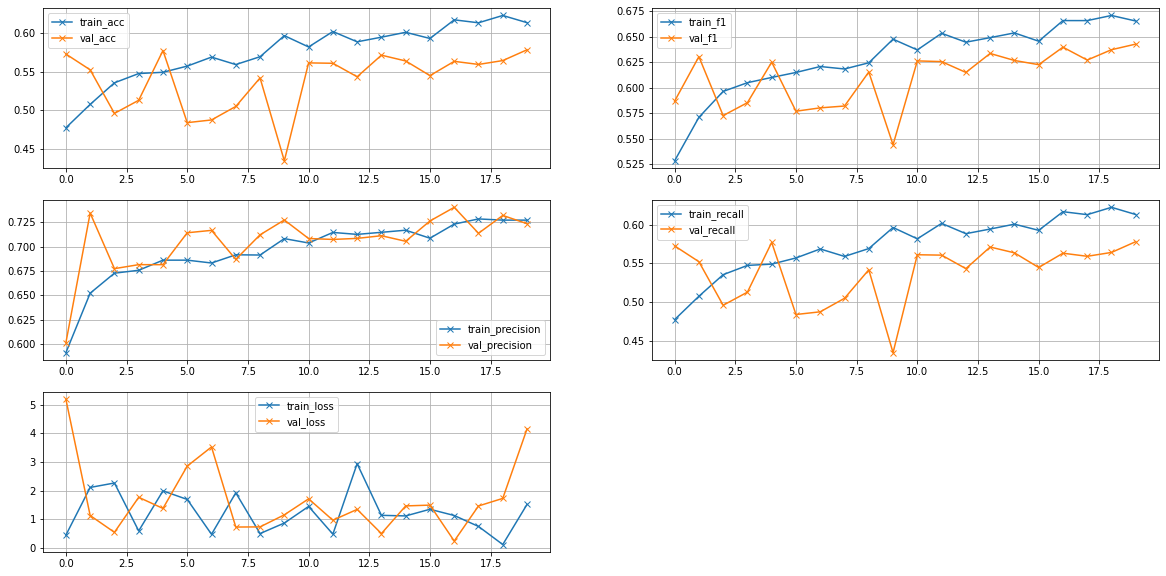

In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

m = torch.nn.Softmax(dim=1)

train_model(
    model=model,
    dataloader=dataloader,
    val_dataloader=val_dataloader,
    model_name="resnet50",
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=20
)

We can find that at 16 epoch, the model has the lowest loss. After 16 epoch, the loss slightly increases, it refers to overfit. Hence, I will stop at 16 epoch, and use this model as the best resnet50 model.

# Testing Set

In [ ]:
resnet18_model = custom_resnet(backbone="resnet18")
resnet18_model.load_state_dict(torch.load("models/resnet18_19.pth"))

<All keys matched successfully>

In [ ]:
resnet18_model.to(device)
test_log_resnet18 = model_testing(resnet18_model, test_dataloader)

  0%|          | 0/251 [00:00<?, ?it/s]

In [ ]:
print("resnet18 preform on testing set")
test_log_resnet18

resnet18 preform on testing set


{'acc': 0.6505242136794808,
 'f1': 0.6907409100893335,
 'precision': 0.7362578285163032,
 'recall': 0.6505242136794808,
 'loss': 0.379764199256897}

In [ ]:
resnet50_model = custom_resnet(backbone="resnet50")
resnet50_model.load_state_dict(torch.load("models/resnet50_16.pth"))

<All keys matched successfully>

In [ ]:
resnet50_model.to(device)
test_log_resnet50 = model_testing(resnet50_model, test_dataloader)

  0%|          | 0/251 [00:00<?, ?it/s]

In [ ]:
print("resnet50 preform on testing set")
test_log_resnet50

resnet50 preform on testing set


{'acc': 0.5496754867698452,
 'f1': 0.6269983439361672,
 'precision': 0.7296362893042073,
 'recall': 0.5496754867698452,
 'loss': 3.1232995986938477}

# Summary

We can find that the performance (f1-score) of resnet18 is better than resnet50. Because in this project, I didn't use pretrain resnet, and we only have around 6,000 images for training, besides, the dataset is very imbalance. Hence, it might not have enough images to update the weights in the resnet50. So in this case, a small model might performs better.